<a href="https://colab.research.google.com/github/trilokimodi/Student-Test-Repository/blob/master/LT2222_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LT2222 V23 Assignment 2: Slot Detection

In this assignment you'll be working with the same data as in Assignment 1 (but with a different focus). This data is made available for the *Slot and Intent Detection for Low Resource
language varieties (SID4LR)* shared task. 

Given an utterance, the shared task consists on identifying the intent of the speaker along with the key spans that require an action from the system. For example, given the utterance *Add reminder to swim at 11am tomorrow*, the intent is *add reminder*, while the slots are *to do* and *datetime*. **In this assignment, we'll focus on the slot detection only.** 

The dataset consists of 13 languages (en, de-st, de, da, nl, it, sr, id, ar, zh, kk, tr, ja).

For more details about the data please check [this paper](https://aclanthology.org/2021.naacl-main.197.pdf) by van der Goot et al., (2021).

## General instructions

You'll do all the work inside this notebook and submit your edited notebook back into Canvas. You many not copy code from elsewhere, but you can use functions from any module currently available on mltgpu, where the notebook will be tested. A major goal of the assignment is, in fact, for you to find them yourself and apply them. Only edit the notebook in the places where we specify you should do so.

You will need to give reasonable, but not excessively verbose, documentation of your code so that we understand what you did.

**The assignment is officially due at 23:59 CET on Wednesday March 8, 2023. There are 33 points and 5 bonus points.**

### 1. Choose a language and download the corresponding train, validation and test data splits.  (2 points)

It doesn't matter if it's the same language as in Assignment 1 or a different one.

https://bitbucket.org/robvanderg/sid4lr/src/master/xSID-0.4/

Store the chosen data into a directory `data/`.

*I downloaded zip file, extracted and manually uploaded the english language files in the data folder.*

### 2. Import all necessary modules here. (1 point)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# An additional module
!pip install conllu
from IPython.display import clear_output
clear_output()
import conllu

In [ ]:
import numpy as np
import pandas as pd
from nltk import everygrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os

### 3. Import the data into Python. (6 points)

Write code to read the data into Python. Here we're focusing on the slot detection task. This means that you need extract the utterances along with their IOB tags. If you're not familiar with the IOB format, check out this Wikipedia entry: [IOB format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)).

**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

*The function takes path, filename as mandatory inputs. After a series of simple operations, the functions returns dataframe. The dataframe contains three columns. The feature column contains full sentences i.e. utterrances and the response column (y) contains slots (IOB). The intent column contains Intent, but it is not used later in the code. By default, the function removes all duplicate entries in the dataset.*

In [ ]:
def get_dataframe_from_Conll(path, filename, canRemoveDuplicates=True):
    dataset_path = os.path.join(path, filename)
    data = open(dataset_path, mode='r', encoding='utf-8')
    data = data.read()
    sentences = conllu.parse(data, fields=["id", "form", "intent", "tag"])
    xT = list()
    yT = list()
    tagT = list()
    for iSentence in sentences:
        sentenceString = list()
        intentString = list()
        tagString = list()
        for iToken in list(iSentence):
            sentenceString.append(iToken['form'].lower())
            intentString.append(iToken['intent'].lower())
            tagString.append(iToken['tag'].lower())
        xT.append(' '.join(sentenceString))
        yT.append(list(set(intentString))[0])
        tagT.append(list(tagString))

    data = {'X': xT, 'y': tagT, 'intent': yT}
    df = pd.DataFrame(data=data)
    if (canRemoveDuplicates == True):
        df.drop_duplicates(subset=['X'], inplace=True)
        df.reset_index(drop=True, inplace=True)
    return df

In [ ]:
# As instructed the data is in data folder and I assume that CWD is one directory before data dir.
dataset = os.path.join(os.getcwd(), 'data')  # To run in MLTGPU
dataset = "/content/drive/My Drive/DIS/Colab/open-data/data/"  # To run in Colab
df_train = get_dataframe_from_Conll(dataset, 'en.train.conll', canRemoveDuplicates=True)
df_valid = get_dataframe_from_Conll(dataset, 'en.valid.conll', canRemoveDuplicates=True)

In [ ]:
df_train.head(5)

,X,y,intent
0,tell me the weather report for half moon bay,"[o, o, o, o, o, o, b-location, i-location, i-l...",weather/find
1,give me the latest forecast for half moon bay,"[o, o, o, b-datetime, o, o, b-location, i-loca...",weather/find
2,give me friday's forecast for half moon bay,"[o, o, b-datetime, o, o, b-location, i-locatio...",weather/find
3,i need to know the latest forecast for half mo...,"[o, o, o, o, o, b-datetime, o, o, b-datetime, ...",weather/find
4,do you have thursday's weather report for half...,"[o, o, o, b-datetime, o, o, o, b-location, i-l...",weather/find


### 4. Think about the features. (1 points)

In this task, we have a one token to one label prediction problem. (You may recall that in assignment 1, we had a one utterance to one label problem). One modeling option here would be to do a bag-of-words for predicting each label individually. 

    1. Why is that not the best for our task?

**Enter your answer below.**

*A bag-of-words approach isn't good because it loses the word order (sequence). For example, the two sentence 'Is this pen ?' and 'This is pen .' will not have any difference for a bag of words approach of the '.' and '?' are ignored. Even with their presence it makes little to no difference.*

*A bag-of-words isn't suitable in slot or intent detection because the slot placing is highly dependent on the word before non o-slot. For example, t'ell me the weather report for Gothenburg' - Here Gothenburg is location and the word 'for' has a significant importance in recognizing. With a bag of words concept the example statment is same as 'tell Gothenburg the report of me weather' which is probably hilarious.*

*As an improvement one can instead use LSTM or recurrent neural networks in general where the sequence has special importance.*

### 5. Build your features. (12 points)

When we predict sequences, we usually use a family of algorithms specialized on sequences, for example, HMMs (which you may recall from language modeling) or CRFs. We are **not** covering these in LT2222. However, we can still approximate a sequence, i.e., use the context, in the form of individual features. For this, we'll represent each training example as:

*previous token, current token, next token, current label*

Extract the training examples so you have your **X and Y variables**. Then, transform them into sparce vectors relying on [Scikit-learn feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#feature-extraction).  


**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

In [ ]:
def add_words_beginning_end(df):
    """
    The goal here is to add a non corpus beginning and end word in each sentence.
    This is done so that the first and last corpus token in each utterances also gets a trigram.
    The added word I chose is 'NonLabelToken'.
    """
    df['X'] = df['X'].apply(lambda x: "{}{}".format('NonLabelToken ', x))
    df['X'] = df['X'].apply(lambda x: "{}{}".format(x, ' NonLabelToken'))
    return df

In [ ]:
df_train = add_words_beginning_end(df_train)
df_valid = add_words_beginning_end(df_valid)

In [ ]:
def append_n_grams_in_df(df, n=3):
    """
    Here an additional column is added to the dataframe. The column trigrams contains list of tuples.
    Each tuple represent each trigram. This is done using nltk everygram function.
    """
    df['trigrams'] = df['X'].apply(lambda utterance: list(everygrams(utterance.split(), n, n)))
    return df

In [ ]:
df_train = append_n_grams_in_df(df_train)
df_valid = append_n_grams_in_df(df_valid)

In [ ]:
def get_trigrams_label(df):
    """
    Here an additional column 'trigram_label' is added to the DF.
    Each row in the column contains a dictionary.
    The dictionary keys are trigram and values is their label i.e. IOB class. 
    One to one mapping is preserved.
    """
    df['trigrams_label'] = df.apply(lambda a: dict(zip(a['trigrams'], a['y'])), axis=1)
    return df

df_train = get_trigrams_label(df_train)
df_valid = get_trigrams_label(df_valid)

In [ ]:
df_train[['X', 'y', 'trigrams_label']].head(10)

,X,y,trigrams_label
0,NonLabelToken tell me the weather report for h...,"[o, o, o, o, o, o, b-location, i-location, i-l...","{('NonLabelToken', 'tell', 'me'): 'o', ('tell'..."
1,NonLabelToken give me the latest forecast for ...,"[o, o, o, b-datetime, o, o, b-location, i-loca...","{('NonLabelToken', 'give', 'me'): 'o', ('give'..."
2,NonLabelToken give me friday's forecast for ha...,"[o, o, b-datetime, o, o, b-location, i-locatio...","{('NonLabelToken', 'give', 'me'): 'o', ('give'..."
3,NonLabelToken i need to know the latest foreca...,"[o, o, o, o, o, b-datetime, o, o, b-datetime, ...","{('NonLabelToken', 'i', 'need'): 'o', ('i', 'n..."
4,NonLabelToken do you have thursday's weather r...,"[o, o, o, b-datetime, o, o, o, b-location, i-l...","{('NonLabelToken', 'do', 'you'): 'o', ('do', '..."
5,NonLabelToken do you have wednesday's weather ...,"[o, o, o, b-datetime, o, o, o, b-location, i-l...","{('NonLabelToken', 'do', 'you'): 'o', ('do', '..."
6,NonLabelToken give me most recent forecast for...,"[o, o, b-datetime, i-datetime, o, o, b-locatio...","{('NonLabelToken', 'give', 'me'): 'o', ('give'..."
7,NonLabelToken give me thursday's half moon bay...,"[o, o, b-datetime, b-location, i-location, i-l...","{('NonLabelToken', 'give', 'me'): 'o', ('give'..."
8,NonLabelToken give me the most recent half moo...,"[o, o, o, b-datetime, i-datetime, b-location, ...","{('NonLabelToken', 'give', 'me'): 'o', ('give'..."
9,NonLabelToken i need half moon bay's weather r...,"[o, o, b-location, i-location, i-location, o, ...","{('NonLabelToken', 'i', 'need'): 'o', ('i', 'n..."


In [ ]:
def get_trigram_label_dataframe(df):
    """
    This function takes in the dataframe created so far and returns a new dataframe.
    The new dataframe contains all trigrams from all utterances with their corresponding labels.
    """
    xT = df['trigrams_label'].apply(lambda x: pd.DataFrame({'X':' '.join(k), 'y':v} for k, v in x.items()))
    xT = xT.to_dict()
    xT = pd.concat(xT.values(), ignore_index=True)
    return xT

In [ ]:
xTrain = get_trigram_label_dataframe(df_train)
xValid = get_trigram_label_dataframe(df_valid)

In [ ]:
vectorizer = CountVectorizer()
transformer = TfidfTransformer(smooth_idf=False)
def get_one_hot_encoded_features(X=xTrain['X'], vectorizer=vectorizer, transformer=transformer, useTfIdf=True, isTrainData=True):
    """
    This function accepts dataframe containing all trigrams. By default a term frequency, inverse document frequency
    is applied on the count matrix returned from CountVectorizer. The TF-IDF can be set to false using parameter in function.
    The function fit_transform must be used for training data and the transform for test purposes to preserve the 
    feature space. 
    
    The TF-IDF assign weights in between 0 and 1. Terms like 'the' are lower in number because they are common to 
    multiple documents. The rare words often get a high value.
    """
    if isTrainData == True:
        if useTfIdf == True:
            return transformer.fit_transform(vectorizer.fit_transform(X))
        else:
            return vectorizer.fit_transform(X)
    
    else:
        if useTfIdf == True:
            return transformer.transform(vectorizer.transform(X))
        else:
            return vectorizer.transform(X)

In [ ]:
XTrain_OneHotEncodedFeatures = get_one_hot_encoded_features(X=xTrain['X'], isTrainData=True)
XValid_OneHotEncodedFeatures = get_one_hot_encoded_features(X=xValid['X'], isTrainData=False)

In [ ]:
XTrain_OneHotEncodedFeatures

<295154x12972 sparse matrix of type '<class 'numpy.float64'>'
	with 807957 stored elements in Compressed Sparse Row format>

### 5. Using Scikit-learn fit either a SVM or a Maximum Entropy model. (3 points)

Write your model inside a function. You'll need to call that function for testing.

(If you run out of memory, or want an even quicker training, train on the validation set and test on the test set.) 

**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

*A label encoder helps in converting the string based response variable to numbers. This doesn't have any significance to model performance, but, it is generally a good practice to convert them. The fit method does the encoding and the function transform converts a given set of string labels to integers labels using the results of fit.*

In [ ]:
labelEncoder = preprocessing.LabelEncoder()
def make_numeric_labels(yTrain=xTrain['y']):
    labelEncoder.fit(list(set(yTrain)))
    
def get_numeric_labels(y=xTrain['y'], labelEncoder=labelEncoder):
    return labelEncoder.transform(y)

make_numeric_labels()

In [ ]:
y_train_true = get_numeric_labels(xTrain['y'])
y_valid_true = get_numeric_labels(xValid['y'])

In [ ]:
def make_SVM_model(one_hot_encoded_features=XTrain_OneHotEncodedFeatures, numeric_labels=y_train_true, maxiter=20):
    """
    The SGDClassifier is used for linear classifiers with stochastic gradient descent learning. For SVM, the loss 
    is hinge. The training iterations - epochs is controlled by max_iter and the early stop is controlled by tol.
    
    The function trains a sparse matrix with classes and returns the same classifer after making a fit.
    
    This function should never be called with test data because fit method should always be fed with training data 
    and not test data. The classifier is used for test but with function other than fit e.g. predict.
    """
    classifier = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=77, max_iter=maxiter, tol=0.1)
    classifier.fit(one_hot_encoded_features.toarray(), numeric_labels)
    return classifier

In [ ]:
# Please uncomment this to train on Training data. The next cell trains using valid data and is much faster.

# classifier = make_SVM_model(maxiter=3)

In [ ]:
classifier = make_SVM_model(one_hot_encoded_features=XValid_OneHotEncodedFeatures, numeric_labels=y_valid_true)

### 6. Evaluate your model using the development or test set. (8 points)

If you arrived here, you've transformed your data in a way that you no longer have complete utterances but a training point per word. This means that your model has learned to predict one label at the time (ie., takes in one example or training point, ouputs one label). 

Now, you need to test your model:

    1. Process your test set in the same way that you processed your training set.
    2. Feed the model one example at the time (call your model after each example).
    3. Compute accuracy per example (you may use Scikit-learn metrics).

**Enter and run your code below. You may insert additional code boxes and text boxes for comments.**

In [ ]:
# The next set of lines processes the test data in the same fashion as train data.
# Note that right function calls are handled inside functions i.e. usage of transform instead of fit_transform etc.

df_test = get_dataframe_from_Conll(dataset, 'en.test.conll', canRemoveDuplicates=True)
df_test = add_words_beginning_end(df_test)
df_test = append_n_grams_in_df(df_test)
df_test = get_trigrams_label(df_test)
xTest = get_trigram_label_dataframe(df_test)
XTest_OneHotEncodedFeatures = get_one_hot_encoded_features(X=xTest['X'], isTrainData=False)
y_test_true = get_numeric_labels(xTest['y'])

In [ ]:
def get_predicted_labels(one_hot_encoded_features_predict=XTest_OneHotEncodedFeatures, classifier=classifier):
    """
    The function predict, uses the fitted model to predict the labels on test or valid data.
    If model fit is improved iteratively, for example in neural networks, then predict function
    can take training labels as well calculate cost for cost functions.
    
    By default the sparse matrix for test data is passed. The function returns predicted labels in encoded form
    because of label encoder in classifier.fit function.
    """
    return classifier.predict(one_hot_encoded_features_predict.toarray())

y_valid_pred = get_predicted_labels(one_hot_encoded_features_predict=XValid_OneHotEncodedFeatures)
y_test_pred = get_predicted_labels(one_hot_encoded_features_predict=XTest_OneHotEncodedFeatures)

In [ ]:
# This cell computes prediction per example. Here each example represents one complete test utterance.
# A mean is computed for each utterances i.e. sum of matched pred and true for each token in the test
# divided by total tokens in the utterances.

# A distrbution is then plotted for these mean calculated.
correctPerExample = list()
for index in range(len(df_test)):
    xTest = get_trigram_label_dataframe(df_test.iloc[[index]])
    XTest_OneHotEncodedFeatures = get_one_hot_encoded_features(X=xTest['X'], isTrainData=False)
    y_test_true = get_numeric_labels(xTest['y'])
    y_test_pred = get_predicted_labels(one_hot_encoded_features_predict=XTest_OneHotEncodedFeatures)
    correctPerExample.append(np.mean(y_test_pred == y_test_true))

Text(0.5, 1.0, 'All data points for per example accuracy in test set')

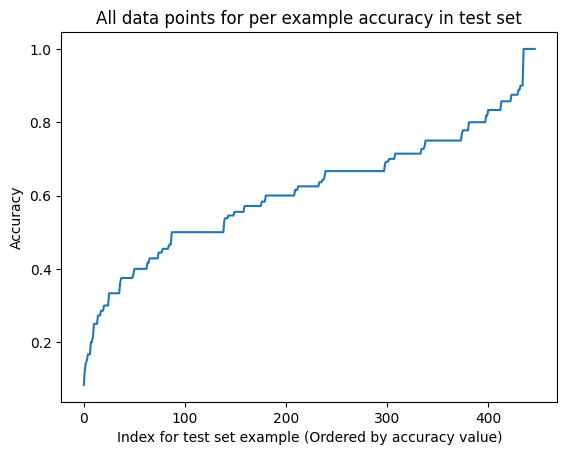

In [ ]:
# Sorted each example accuracy value in plot.
plt.plot(sorted(correctPerExample, reverse=False))
plt.xlabel('Index for test set example (Ordered by accuracy value)')
plt.ylabel('Accuracy')
plt.title('All data points for per example accuracy in test set')

Text(0.5, 1.0, 'Histogram to show per example accuracy')

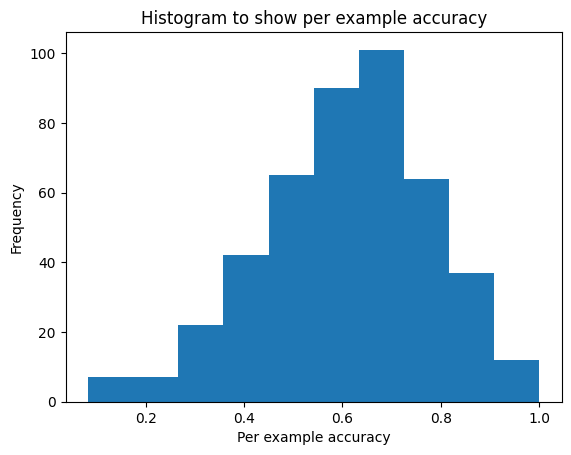

In [ ]:
# Histogram of the each example accuracy value.
plt.hist(correctPerExample)
plt.xlabel('Per example accuracy')
plt.ylabel('Frequency')
plt.title('Histogram to show per example accuracy')

# Bonus 1 point: Compute the accuracy for the entire test set.  

*The method accuracy_score, precision_score, recall_score, f1_score are all used to evaluate model performance. All these methods also support multi-class labels which is the case here. For multi-class labels, average 'macro' is used to treat all classes equally.*

*These results can be influence with the average method chosen, and depending on the problem statement, they can chosen if for example true negatives is preferred over false negatives.* 

*For text classification, I think all classes should be treated equally and hence I chose macro.*

In [ ]:
def get_evaluation_metrics_scores(yTrue, yPred):
    model_accuracy = accuracy_score(yTrue, yPred)
    print(f'The accuracy of the model = {model_accuracy:.4f}')

    model_precision = precision_score(yTrue, yPred, average='macro')
    print(f'The precision of the model with macro average = {model_precision:.4f}')

    model_recall = recall_score(yTrue, yPred, average='macro')
    print(f'The recall of the model with macro average = {model_recall:.4f}')

    model_f1score = f1_score(yTrue, yPred, average='macro')
    print(f'The f1 score of the model with macro average = {model_f1score:.4f}')

In [ ]:
get_evaluation_metrics_scores(y_test_true, y_test_pred)

The accuracy of the model = 0.6667
The precision of the model with macro average = 0.3889
The recall of the model with macro average = 0.4375
The f1 score of the model with macro average = 0.3929


/usr/local/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*The model accuracy when tested on test data resulted in 66.67%.*
*whereas the model precision, recall and f1 scores all turned out to be in range* [39, 45]%.

*Even though the accuracy is relatively high, the model is not great enough. Accuracy can lead to biased results when there is a class imbalance in the training data. This can be seen in the histogram plot shown below.*

*The F1-score reflects better performance of model when there is class imbalance. Since the F1-score is below 50%, we can state that there is still a higher scope to improve model performance.*

*These scores as using TF-IDF matrix. The non TF-IDF matrix i.e. counts based one resulted in accuracy of 61%.*

Text(0.5, 1.0, 'Histogram to show class imbalance')

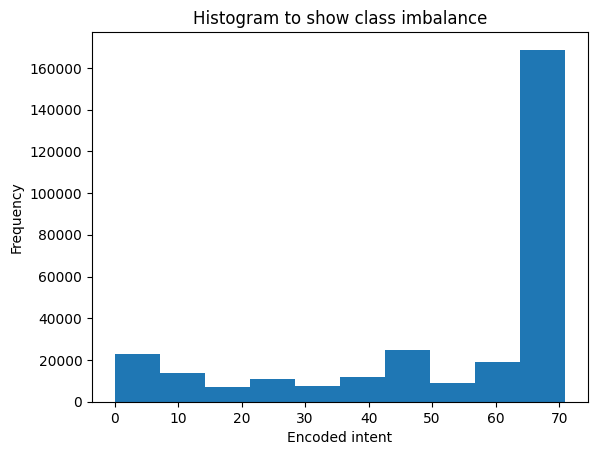

In [ ]:
plt.hist(y_train_true)
plt.xlabel('Encoded intent')
plt.ylabel('Frequency')
plt.title('Histogram to show class imbalance')

# Bonus 4 points: Find out what are the best features per class.

In [ ]:
# The below code prints out features with highest coefficient value i.e. weight for each class. 
# Some classes have no weights, most likely due to either a poor fit or under-trained model.

bfpc = {'Class': labelEncoder.classes_, 'Feature with highest coefficient': [None] * len(labelEncoder.classes_)}
for index, label in enumerate(labelEncoder.classes_):
    if index in classifier.classes_:
        coeffIndex = list(classifier.classes_).index(index)
        highestCoeff = np.argsort(classifier.coef_[coeffIndex])[-1:][0]
        bfpc['Feature with highest coefficient'][index] = vectorizer.get_feature_names_out()[highestCoeff]

bfpc = pd.DataFrame(data=bfpc, columns=['Class', 'Feature with highest coefficient'])
print(bfpc)

                      Class Feature with highest coefficient
0    b-alarm/alarm_modifier                             None
1                   b-album                            album
2                  b-artist                              add
3             b-best_rating                               of
4   b-condition_description                           nearby
..                      ...                              ...
67                   i-sort                           highly
68                  i-track                             None
69      i-weather/attribute                             heat
70                        o                    nonlabeltoken
71      orecurring_datetime                             None

[72 rows x 2 columns]
